

import urlretirive and os

In [ ]:
%pip install rasterio
%pip install urllib
%pip install matplotlib
from urllib.request import urlretrieve
import os
import matplotlib.pyplot as plt
import rasterio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.5/21.5 MB 74.6 MB/s eta 0:00:00
ERROR: Could not find a version that satisfies the requirement urllib (from versions: none)
ERROR: No matching distribution found for urllib


Define where our file is located and name the file and then save it using urlretrive

In [ ]:
url = ("https://ut-austin.maps.arcgis.com/sharing/rest/content/items/e222eb478a76419a804ea0acd1724c07/data")

#If working locally, you might want to specifiy a path
filename = "austin_naip.tif"


urlretrieve(url, filename)


('austin_naip.tif', <http.client.HTTPMessage at 0x795bae8f3730>)

Plot the multiband raster image using geowombat (gw)

Notice we define the bands and band order



plt.subplots() is a function that returns a tuple containing a figure and axes object(s). Thus when using fig, ax = plt.subplots() you unpack this tuple into the variables fig and ax

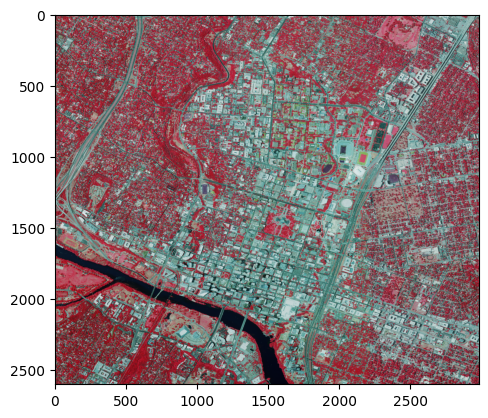

In [ ]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt
raster = rasterio.open("austin_naip.tif")

# Normalize bands into 0.0 - 1.0 scale
def normalize(array):
    array_min, array_max = array.min(), array.max()
    return (array - array_min) / (array_max - array_min)

# Convert to numpy arrays
nir = raster.read(1)
red = raster.read(2)
green = raster.read(3)
blue = raster.read(4)

# Normalize band DN
nir_norm = normalize(nir)
red_norm = normalize(red)
green_norm = normalize(green)
blue_norm = normalize(blue)

# Stack bands
nrg = np.dstack((nir_norm, red_norm, green_norm))

# View the color composite
plt.imshow(nrg)

Produce an NDVI image

(NIR - R) / (NIR + R)

In [ ]:
import rasterio
import numpy
import matplotlib.pyplot as plt

# Do not display error when divided by zero

numpy.seterr(divide='ignore', invalid='ignore')

# NDVI
ndvi = (nir.astype(float) - red.astype(float)) / (nir.astype(float) + red.astype(float))


In [ ]:
print(numpy.nanmin(ndvi))
print(numpy.nanmax(ndvi))

-0.918918918918919
0.646551724137931


Produce a new file with metadata for the NDVI Image

In [ ]:
# get the metadata of original GeoTIFF:
meta = raster.meta
print(meta)

# get the dtype of our NDVI array:
ndvi_dtype = ndvi.dtype
print(ndvi_dtype)

# set the source metadata as kwargs we'll use to write the new data:
kwargs = meta

# update the 'dtype' value to match our NDVI array's dtype:
kwargs.update(dtype=ndvi_dtype)

# update the 'count' value since our output will no longer be a 4-band image:
kwargs.update(count=1)

# Finally, use rasterio to write new raster file 'data/ndvi.tif':
with rasterio.open('ndvi.tif', 'w', **kwargs) as dst:
        dst.write(ndvi, 1)

{'driver': 'GTiff', 'dtype': 'float64', 'nodata': None, 'width': 2982, 'height': 2600, 'count': 4, 'crs': CRS.from_epsg(4326), 'transform': Affine(1.796630568239043e-05, 0.0, -97.76895243090382,
       0.0, -1.796630568239043e-05, 30.30080335405034)}
float64


Now we are going to plot our NDVI data. The first step is choosing colors and matching the color scheme to the NDVI data


Here we are defining a custom normalization class called MidpointNormalize to center the colormap around a specific midpoint. This is useful for data like NDVI, where the most interesting values are often clustered around a central point.

Here's a breakdown:

Import: from matplotlib import colors imports the necessary module for working with colormaps.

Class Definition: class MidpointNormalize(colors.Normalize) defines a new class inheriting from colors.Normalize, which is the base class for normalization in Matplotlib.

Constructor (__init__):

Takes optional arguments vmin, vmax, and midpoint.
Stores the provided midpoint value for later use.
Calls the constructor of the parent class (colors.Normalize) to initialize the basic normalization behavior.
Call Method (__call__):

This method is executed when the normalization object is called with a value.
It maps the input value to a normalized range between 0 and 1, centered around the midpoint.
It uses numpy.interp to linearly interpolate the value between the minimum, midpoint, and maximum values.
It returns a masked array, where values outside the valid range are masked using numpy.isnan.

In [ ]:
from matplotlib import colors


class MidpointNormalize(colors.Normalize):

    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        colors.Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):

        x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
        return numpy.ma.masked_array(numpy.interp(value, x, y), numpy.isnan(value))

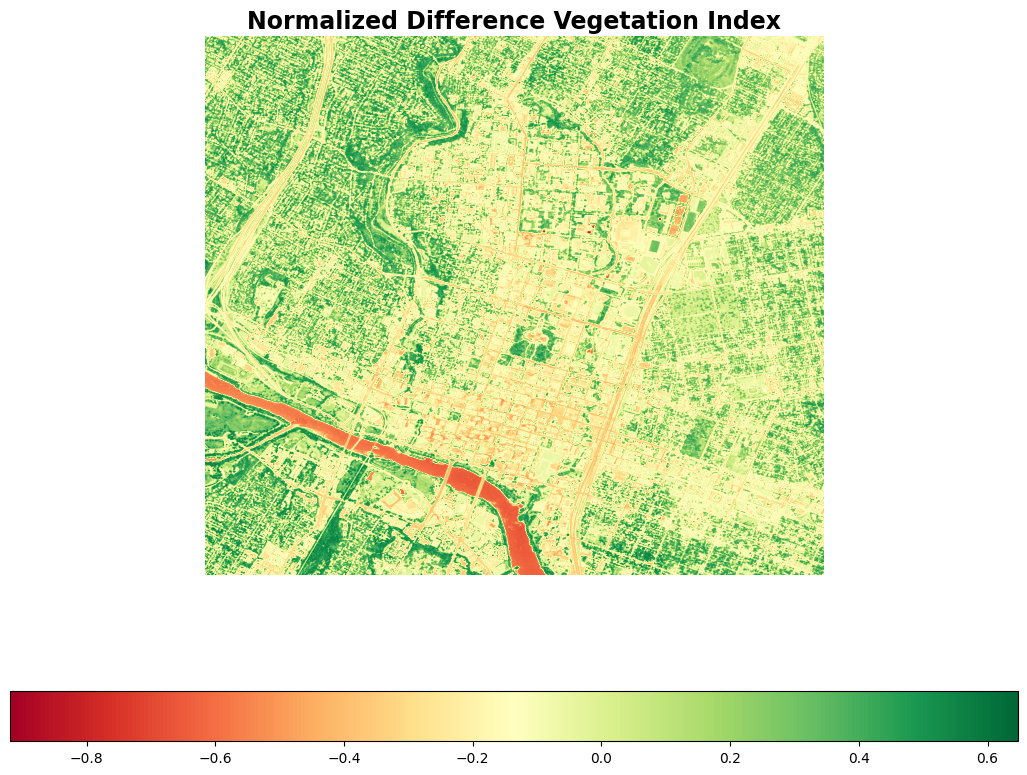

In [ ]:
import numpy
import matplotlib.pyplot as plt
# Set min/max values from NDVI range for image

min=numpy.nanmin(ndvi)
max=numpy.nanmax(ndvi)

# Set our custom midpoint for most effective NDVI analysis
mid=0.1

# Setting color scheme ref:https://matplotlib.org/users/colormaps.html as a reference
colormap = plt.cm.RdYlGn
norm = MidpointNormalize(vmin=min, vmax=max, midpoint=mid)
fig = plt.figure(figsize=(20,10))


ax = fig.add_subplot(111)

# Use 'imshow' to specify the input data, colormap, min, max, and norm for the colorbar
cbar_plot = ax.imshow(ndvi, vmin=min, vmax=max, cmap=colormap)


# Turn off the display of axis labels
ax.axis('off')

# Set a title
ax.set_title('Normalized Difference Vegetation Index', fontsize=17, fontweight='bold')

# Configure the colorbar
cbar = fig.colorbar(cbar_plot, orientation='horizontal', shrink=0.65)

# Call 'savefig' to save this plot to an image file
fig.savefig("ndvi-image.png", dpi=200, bbox_inches='tight', pad_inches=0.7)

# let's visualize
plt.show()

On your own:

Expiriement with a different image of your choice (e.g., Landsat or a different NAIP image)

Choose a different index to work with (e.g., EVI or NDWI)